In [1]:
import sgkit as sg
import xarray as xr
import pandas as pd
import allel
from pathlib import Path
from sgkit.io.plink import read_plink
from sgkit.stats.pca import count_call_alternate_alleles
from sgkit.stats.aggregation import call_rate
from dask.diagnostics import ProgressBar, ResourceProfiler
from bokeh.io import output_notebook
output_notebook();

Loading BokehJS ...

In [6]:
def save_zarr(ds, path, mode='w', **kwargs):
    for v in ds:
        ds[v].encoding.pop('chunks', None)
    ds.chunk(chunks='auto').to_zarr(str(path), mode=mode, **kwargs)
        
def load_zarr(path):
    return xr.open_zarr(str(path), concat_characters=False)

In [3]:
data_dir, cache_dir = Path('/data/disk1/dev/gwas/tutorial/2_PS_GWAS'), Path('cache')
data_dir, cache_dir

(PosixPath('/data/disk1/dev/gwas/tutorial/2_PS_GWAS'), PosixPath('cache'))

In [2]:
ds = read_plink(path=data_dir / '1kG_MDS2')
ds

<xarray.Dataset>
Dimensions:             (alleles: 2, ploidy: 2, samples: 629, variants: 9007422)
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    variant_contig      (variants) int16 0 0 0 0 0 0 0 ... 21 21 21 21 21 21 21
    variant_position    (variants) int32 dask.array<chunksize=(1944463,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 dask.array<chunksize=(1944463, 1), meta=np.ndarray>
    sample_id           (samples) <U7 dask.array<chunksize=(629,), meta=np.ndarray>
    call_genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(96854, 629, 2), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(96854, 629, 2), meta=np.ndarray>
    variant_id          (variants) <U16 dask.array<chunksize=(1944463,), meta=np.ndarray>
    sample_family_id    (samples) <U1 dask.array<chunksize=(629,), meta=np.ndarray>
    sample_paternal_id  (samples) <U4 dask.array<chunksize=(629,), meta=np.ndarray>
    sample_maternal_id  (samples) <U4 dask.array<chunksize=(629,), meta=np.ndarray>
    sample_sex          (samples) int8 dask.array<chunksize=(629,), meta=np.ndarray>
    sample_phenotype    (samples) int8 dask.array<chunksize=(629,), meta=np.ndarray>
Attributes:
    contigs:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',...

In [9]:
%%time
with ProgressBar():
    save_zarr(ds, cache_dir / 'ds.zarr')

[########################################] | 100% Completed | 36.2s
CPU times: user 5min 5s, sys: 3min 13s, total: 8min 18s
Wall time: 36.3 s


In [14]:
ds = load_zarr(cache_dir / 'ds.zarr')
ds

,Array,Chunk
Bytes,11.33 GB,121.84 MB
Shape,"(9007422, 629, 2)","(96854, 629, 2)"
Count,94 Tasks,93 Chunks
Type,int8,numpy.ndarray
,Array,Chunk
Bytes,11.33 GB,121.84 MB
Shape,"(9007422, 629, 2)","(96854, 629, 2)"
Count,94 Tasks,93 Chunks
Type,bool,numpy.ndarray
,Array,Chunk


In [15]:
def qc(ds):    
    return (
        ds
        .pipe(sg.variant_stats)
        .assign(variant_af=lambda ds: ds.variant_allele_frequency.min(dim="alleles"))
        .assign(sample_call_rate=lambda ds: call_rate(ds, dim="variants").sample_call_rate)
        .pipe(lambda ds: ds.sel(variants=ds.variant_call_rate > .98))
        .pipe(lambda ds: ds.sel(samples=ds.sample_call_rate > .98))
        .pipe(lambda ds: ds.sel(variants=ds.variant_af > .05))
    )

In [16]:
%%time
with ProgressBar(), ResourceProfiler() as rprof:
    ds_qc = qc(ds)
ds_qc

[########################################] | 100% Completed | 13.1s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.7s
[########################################] | 100

/home/eczech/miniconda3/envs/sgkit-dev/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  8.6s
[                                        ] | 0% Completed |  0.1s

/home/eczech/miniconda3/envs/sgkit-dev/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.9s
[########################################] | 100

,Array,Chunk
Bytes,46.47 MB,549.30 kB
Shape,"(5808200,)","(68662,)"
Count,745 Tasks,93 Chunks
Type,int64,numpy.ndarray
,Array,Chunk
Bytes,46.47 MB,549.30 kB
Shape,"(5808200,)","(68662,)"
Count,838 Tasks,93 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [17]:
rprof.visualize()

Figure(id='1002', ...)

In [24]:
%%time
with ProgressBar():
    save_zarr(ds_qc, cache_dir / 'ds_qc.zarr')

[########################################] | 100% Completed |  1min 12.0s
CPU times: user 18min 8s, sys: 37.9 s, total: 18min 46s
Wall time: 1min 12s


In [29]:
ds_qc = load_zarr(cache_dir / 'ds_qc.zarr')
ds_qc

,Array,Chunk
Bytes,6.84 GB,68.42 MB
Shape,"(5808200, 589, 2)","(58082, 589, 2)"
Count,101 Tasks,100 Chunks
Type,int8,numpy.ndarray
,Array,Chunk
Bytes,6.84 GB,68.42 MB
Shape,"(5808200, 589, 2)","(58082, 589, 2)"
Count,101 Tasks,100 Chunks
Type,int8,numpy.ndarray
,Array,Chunk


In [30]:
def ld_prune(ds):
    return (
        ds
        .pipe(count_call_alternate_alleles)
        .pipe(lambda ds: ds.sel(variants=allel.locate_unlinked(
            ds.call_alternate_allele_count.values, size=50, step=5, threshold=0.2
        )))
    )

In [ ]:
%%time
with ProgressBar():
    ds_ldp = ld_prune(ds_qc)
ds_ldp

In [31]:
%%time
with ProgressBar():
    save_zarr(ds_ldp, cache_dir / 'ds_ldp.zarr')

[########################################] | 100% Completed | 12.2s
CPU times: user 3min 17s, sys: 29.5 s, total: 3min 47s
Wall time: 55.2 s


### PCA

In [7]:
ds_ldp = load_zarr(cache_dir / 'ds_ldp.zarr')
ds_ldp

<xarray.Dataset>
Dimensions:                      (alleles: 2, ploidy: 2, samples: 589, variants: 729066)
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    call_alternate_allele_count  (variants, samples) int16 dask.array<chunksize=(113936, 589), meta=np.ndarray>
    call_genotype                (variants, samples, ploidy) int8 dask.array<chunksize=(113936, 589, 2), meta=np.ndarray>
    call_genotype_mask           (variants, samples, ploidy) int8 dask.array<chunksize=(113936, 589, 2), meta=np.ndarray>
    sample_call_rate             (samples) float64 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_family_id             (samples) <U1 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_id                    (samples) <U7 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_maternal_id           (samples) <U4 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_paternal_id           (samples) <U4 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_phenotype             (samples) int8 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_sex                   (samples) int8 dask.array<chunksize=(589,), meta=np.ndarray>
    variant_af                   (variants) float64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_allele               (variants, alleles) |S1 dask.array<chunksize=(729066, 2), meta=np.ndarray>
    variant_allele_count         (variants, alleles) uint64 dask.array<chunksize=(729066, 2), meta=np.ndarray>
    variant_allele_frequency     (variants, alleles) float64 dask.array<chunksize=(729066, 2), meta=np.ndarray>
    variant_allele_total         (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_call_rate            (variants) float64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_contig               (variants) int16 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_id                   (variants) <U16 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_called             (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_het                (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_hom_alt            (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_hom_ref            (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_non_ref            (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_position             (variants) int32 dask.array<chunksize=(729066,), meta=np.ndarray>

In [15]:
def impute(ac):
    return xr.where(ac < 0, ac.mean(dim='samples'), ac)

ds_pca = sg.pca(
    ds_ldp
    .assign(call_alternate_allele_count=impute(ds_ldp.call_alternate_allele_count)), 
    n_components=2
)
ds_pca

<xarray.Dataset>
Dimensions:                              (alleles: 2, components: 2, ploidy: 2, samples: 589, variants: 729066)
Dimensions without coordinates: alleles, components, ploidy, samples, variants
Data variables:
    sample_pca_projection                (samples, components) float64 dask.array<chunksize=(589, 2), meta=np.ndarray>
    sample_pca_component                 (variants, components) float64 dask.array<chunksize=(113936, 2), meta=np.ndarray>
    sample_pca_explained_variance        (components) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_pca_explained_variance_ratio  (components) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_pca_loading                   (variants, components) float64 dask.array<chunksize=(113936, 2), meta=np.ndarray>
    call_alternate_allele_count          (variants, samples) float64 dask.array<chunksize=(113936, 589), meta=np.ndarray>
    call_genotype                        (variants, samples, ploidy) int8 dask.array<chunksize=(113936, 589, 2), meta=np.ndarray>
    call_genotype_mask                   (variants, samples, ploidy) int8 dask.array<chunksize=(113936, 589, 2), meta=np.ndarray>
    sample_call_rate                     (samples) float64 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_family_id                     (samples) <U1 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_id                            (samples) <U7 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_maternal_id                   (samples) <U4 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_paternal_id                   (samples) <U4 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_phenotype                     (samples) int8 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_sex                           (samples) int8 dask.array<chunksize=(589,), meta=np.ndarray>
    variant_af                           (variants) float64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_allele                       (variants, alleles) |S1 dask.array<chunksize=(729066, 2), meta=np.ndarray>
    variant_allele_count                 (variants, alleles) uint64 dask.array<chunksize=(729066, 2), meta=np.ndarray>
    variant_allele_frequency             (variants, alleles) float64 dask.array<chunksize=(729066, 2), meta=np.ndarray>
    variant_allele_total                 (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_call_rate                    (variants) float64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_contig                       (variants) int16 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_id                           (variants) <U16 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_called                     (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_het                        (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_hom_alt                    (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_hom_ref                    (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_non_ref                    (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_position                     (variants) int32 dask.array<chunksize=(729066,), meta=np.ndarray>

In [16]:
%%time
with ProgressBar():
    save_zarr(ds_pca, cache_dir / 'ds_pca.zarr')

[########################################] | 100% Completed | 26.0s
CPU times: user 4min 57s, sys: 1min 32s, total: 6min 29s
Wall time: 26.1 s


In [18]:
pcs = ds_pca.sample_pca_projection.values

In [19]:
import matplotlib.pyplot as plt

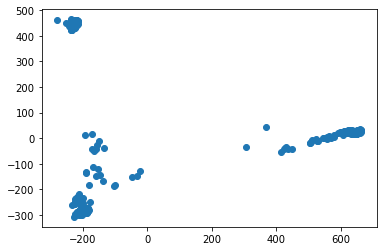

In [20]:
plt.scatter(pcs[:, 0], pcs[:, 1])

### Attach Metadata

In [39]:
df = pd.read_csv(data_dir / '20100804.ALL.panel.clean', sep='\t')
df

,s,pop,race
0,HG00098,GBR,EUR
1,HG00100,GBR,EUR
2,HG00106,GBR,EUR
3,HG00112,GBR,EUR
4,HG00114,GBR,EUR
...,...,...,...
624,NA20816,TSI,EUR
625,NA20818,TSI,EUR
626,NA20819,TSI,EUR
627,NA20826,TSI,EUR


In [40]:
ds_pca.sample_id.values

array(['HG00098', 'HG00100', 'HG00106', 'HG00112', 'HG00114', 'HG00116',
       'HG00117', 'HG00118', 'HG00119', 'HG00120', 'HG00122', 'HG00123',
       'HG00124', 'HG00126', 'HG00131', 'HG00141', 'HG00142', 'HG00143',
       'HG00144', 'HG00145', 'HG00146', 'HG00147', 'HG00148', 'HG00149',
       'HG00150', 'HG00151', 'HG00152', 'HG00153', 'HG00156', 'HG00158',
       'HG00159', 'HG00160', 'HG00171', 'HG00173', 'HG00174', 'HG00176',
       'HG00177', 'HG00178', 'HG00179', 'HG00180', 'HG00181', 'HG00182',
       'HG00183', 'HG00185', 'HG00186', 'HG00187', 'HG00188', 'HG00189',
       'HG00190', 'HG00231', 'HG00239', 'HG00242', 'HG00243', 'HG00244',
       'HG00245', 'HG00247', 'HG00258', 'HG00262', 'HG00264', 'HG00265',
       'HG00266', 'HG00267', 'HG00269', 'HG00270', 'HG00272', 'HG00306',
       'HG00308', 'HG00311', 'HG00312', 'HG00357', 'HG00361', 'HG00366',
       'HG00367', 'HG00368', 'HG00369', 'HG00372', 'HG00373', 'HG00377',
       'HG00380', 'HG00403', 'HG00404', 'HG00553', 

In [35]:
ds_pca = xr.open_zarr('/tmp/ds_ldp.zarr', concat_characters=False)
ds_pca

<xarray.Dataset>
Dimensions:                      (alleles: 2, ploidy: 2, samples: 589, variants: 729066)
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    call_alternate_allele_count  (variants, samples) int16 dask.array<chunksize=(113936, 589), meta=np.ndarray>
    call_genotype                (variants, samples, ploidy) int8 dask.array<chunksize=(113936, 589, 2), meta=np.ndarray>
    call_genotype_mask           (variants, samples, ploidy) int8 dask.array<chunksize=(113936, 589, 2), meta=np.ndarray>
    sample_call_rate             (samples) float64 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_family_id             (samples) <U1 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_id                    (samples) <U7 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_maternal_id           (samples) <U4 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_paternal_id           (samples) <U4 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_phenotype             (samples) int8 dask.array<chunksize=(589,), meta=np.ndarray>
    sample_sex                   (samples) int8 dask.array<chunksize=(589,), meta=np.ndarray>
    variant_af                   (variants) float64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_allele               (variants, alleles) |S1 dask.array<chunksize=(729066, 2), meta=np.ndarray>
    variant_allele_count         (variants, alleles) uint64 dask.array<chunksize=(729066, 2), meta=np.ndarray>
    variant_allele_frequency     (variants, alleles) float64 dask.array<chunksize=(729066, 2), meta=np.ndarray>
    variant_allele_total         (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_call_rate            (variants) float64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_contig               (variants) int16 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_id                   (variants) <U16 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_called             (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_het                (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_hom_alt            (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_hom_ref            (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_n_non_ref            (variants) int64 dask.array<chunksize=(729066,), meta=np.ndarray>
    variant_position             (variants) int32 dask.array<chunksize=(729066,), meta=np.ndarray>

-----

In [43]:
# See https://github.com/related-sciences/gwas-analysis/blob/master/notebooks/tutorial/02-population-stratification/ps-plink.ipynb
ds_pca = (
    ds
    .pipe(sg.variant_stats)
    .assign(variant_af=lambda ds: ds.variant_allele_frequency.min(dim="alleles"))
    .assign(sample_call_rate=lambda ds: call_rate(ds, dim="variants").sample_call_rate)
    .pipe(lambda ds: ds.sel(variants=ds.variant_call_rate > .98))
    .pipe(lambda ds: ds.sel(samples=ds.sample_call_rate > .98))
    .pipe(lambda ds: ds.sel(variants=ds.variant_af > .05))
    .pipe(count_call_alternate_alleles)
    .pipe(lambda ds: ds.sel(variants=allel.locate_unlinked(
        ds.call_alternate_allele_count.values, size=50, step=5, threshold=0.2
    )))
)
ds_pca

<xarray.Dataset>
Dimensions:                      (alleles: 2, ploidy: 2, samples: 602, variants: 1007)
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    call_alternate_allele_count  (variants, samples) int16 dask.array<chunksize=(1007, 602), meta=np.ndarray>
    variant_n_called             (variants) int64 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_call_rate            (variants) float64 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_n_het                (variants) int64 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_n_hom_ref            (variants) int64 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_n_hom_alt            (variants) int64 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_n_non_ref            (variants) int64 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_allele_count         (variants, alleles) uint64 1161 97 ... 912 346
    variant_allele_total         (variants) int64 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_allele_frequency     (variants, alleles) float64 dask.array<chunksize=(1007, 2), meta=np.ndarray>
    call_genotype                (variants, samples, ploidy) int8 dask.array<chunksize=(1007, 602, 2), meta=np.ndarray>
    call_genotype_mask           (variants, samples, ploidy) bool dask.array<chunksize=(1007, 602, 2), meta=np.ndarray>
    sample_family_id             (samples) <U1 dask.array<chunksize=(602,), meta=np.ndarray>
    sample_id                    (samples) <U7 dask.array<chunksize=(602,), meta=np.ndarray>
    sample_maternal_id           (samples) <U4 dask.array<chunksize=(602,), meta=np.ndarray>
    sample_paternal_id           (samples) <U4 dask.array<chunksize=(602,), meta=np.ndarray>
    sample_phenotype             (samples) int8 dask.array<chunksize=(602,), meta=np.ndarray>
    sample_sex                   (samples) int8 dask.array<chunksize=(602,), meta=np.ndarray>
    variant_allele               (variants, alleles) |S1 dask.array<chunksize=(1007, 1), meta=np.ndarray>
    variant_contig               (variants) int16 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_id                   (variants) <U16 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_position             (variants) int32 dask.array<chunksize=(1007,), meta=np.ndarray>
    variant_af                   (variants) float64 dask.array<chunksize=(1007,), meta=np.ndarray>
    sample_call_rate             (samples) float64 dask.array<chunksize=(602,), meta=np.ndarray>